姓名：白思萌
学号：3120190975
学院：计算机学院

# Wine Reviews 数据集

## 数据准备

数据集主页：https://www.kaggle.com/zynicide/wine-reviews

首先，导入数据分析与处理所需的数据模块。

In [1]:
import pandas as pd
import itertools
import collections
import numbers
import typing

将数据集进行导入。

In [2]:
wine = pd.read_csv('winemag-data-130k-v2.csv')
print('%d columns' % len(wine.columns))
print('%d rows' % len(wine.index))

14 columns
129971 rows


数据共有14列，129971行。取前5行数据进行展示。

In [3]:
wine.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## 对数据集进行处理，转换成适合进行关联规则挖掘的形式

经对数据的分析后，此次将对葡萄酒的country，designation，province，variety，winery属性进行关系分析。因此将这五列数据进行抽取，缺失值用nan代替。

In [4]:
columns = [
    'country',
    'designation', 
    'province', 
    'variety', 
    'winery'
]
wine = wine[columns].fillna('nan')

transactions = wine.values.tolist()

print('%d transactions.' % len(transactions), end='\n\n')
for idx, t in enumerate(transactions[:5]):
    print('%d:' % idx, t, end='\n\n')

129971 transactions.

0: ['Italy', 'Vulkà Bianco', 'Sicily & Sardinia', 'White Blend', 'Nicosia']

1: ['Portugal', 'Avidagos', 'Douro', 'Portuguese Red', 'Quinta dos Avidagos']

2: ['US', 'nan', 'Oregon', 'Pinot Gris', 'Rainstorm']

3: ['US', 'Reserve Late Harvest', 'Michigan', 'Riesling', 'St. Julian']

4: ['US', "Vintner's Reserve Wild Child Block", 'Oregon', 'Pinot Noir', 'Sweet Cheeks']



以上结果表明对5列属性抽取成功，共包含129971行数据。前5行数据如上所示。

## 找出频繁模式

### 算法构造

采用Apriori算法找出频繁项集。首先构造find_itemsets()函数用于找出频繁项集。

In [5]:
def join_step(itemsets: typing.List[tuple]):
    i = 0
    while i < len(itemsets):
        skip = 1
        *itemset_first, itemset_last = itemsets[i]
        tail_items = [itemset_last]
        tail_items_append = tail_items.append  # Micro-optimization
        for j in range(i + 1, len(itemsets)):
            *itemset_n_first, itemset_n_last = itemsets[j]
            if itemset_first == itemset_n_first:
                tail_items_append(itemset_n_last)
                skip += 1
            else:
                break
        itemset_first = tuple(itemset_first)
        for a, b in sorted(itertools.combinations(tail_items, 2)):
            yield itemset_first + (a,) + (b,)
        i += skip


def prune_step(
    itemsets: typing.List[tuple], 
    possible_itemsets: typing.List[tuple]
):
    itemsets = set(itemsets)
    for possible_itemset in possible_itemsets:
        for i in range(len(possible_itemset) - 2):
            removed = possible_itemset[:i] + possible_itemset[i + 1 :]
            if removed not in itemsets:
                break
        else:
            yield possible_itemset


def apriori_gen(itemsets: typing.List[tuple]):
    possible_extensions = join_step(itemsets)
    yield from prune_step(itemsets, possible_extensions)


def find_itemsets(
    transactions: typing.List[tuple],
    min_support: float,
    max_length: int = 8,
    verbosity: int = 0,
):
    transaction_sets = [set(t) for t in transactions if len(t) > 0]
    transactions = transaction_sets
    use_transaction = collections.defaultdict(lambda: True)

    if verbosity > 0:
        print("开始寻找频繁项集")
        print(" 项集长度为1：")

    counts = collections.defaultdict(int)
    num_transactions = 0
    for transaction in transactions:
        num_transactions += 1  # Increment counter for transactions
        for item in transaction:
            counts[item] += 1  # Increment counter for single-item itemsets

    large_itemsets = [
        (i, c)
        for (i, c) in counts.items()
        if (c / num_transactions) >= min_support
    ]

    if verbosity > 0:
        num_cand, num_itemsets = len(counts.items()), len(large_itemsets)
        print(" 找到 {} 个长度为1的项集".format(num_cand))
        print("  找到 {} 个长度为1的频繁项集".format(num_itemsets))

    # If large itemsets were found, convert to dictionary
    if large_itemsets:
        large_itemsets = {1: {(i,): c for (i, c) in sorted(large_itemsets)}}
    else:
        return dict(), num_transactions

    issubset = set.issubset  # Micro-optimization
    k = 2
    while large_itemsets[k - 1] and (max_length != 1):
        if verbosity > 0:
            print("项集长度为 {} ：".format(k))
        itemsets_list = list(large_itemsets[k - 1].keys())
        C_k = list(apriori_gen(itemsets_list))
        C_k_sets = [set(itemset) for itemset in C_k]

        if verbosity > 0:
            print("  找到 {} 个长度为 {} 的项集".format(len(C_k), k))
        if not C_k:
            break

        # Prepare counts of candidate itemsets (from the pruen step)
        candidate_itemset_counts = collections.defaultdict(int)
        if verbosity > 1:
            print("    继续寻找")
        for row, transaction in enumerate(transactions):
            if not use_transaction[row]:
                continue
            found_any = False
            for candidate, candidate_set in zip(C_k, C_k_sets):
                if issubset(candidate_set, transaction):
                    candidate_itemset_counts[candidate] += 1
                    found_any = True
            if not found_any:
                use_transaction[row] = False

        C_k = [
            (i, c)
            for (i, c) in candidate_itemset_counts.items()
            if (c / num_transactions) >= min_support
        ]
        if not C_k:
            break

        large_itemsets[k] = {i: c for (i, c) in sorted(C_k)}

        if verbosity > 0:
            num_found = len(large_itemsets[k])
            pp = "  找到 {} 个长度为 {} 的频繁项集".format(num_found, k)
            print(pp)
        k += 1
        if k > max_length:
            break

    if verbosity > 0:
        print("寻找结束")
    return large_itemsets, num_transactions

### 算法实现

找出支持度大于等于0.05的频繁项集。

In [6]:
itemsets, num_trans = find_itemsets(
    transactions=transactions,
    min_support=0.05,
    verbosity=1,
)

开始寻找频繁项集
 项集长度为1：
 找到 54849 个长度为1的项集
  找到 12 个长度为1的频繁项集
项集长度为 2 ：
  找到 66 个长度为 2 的项集
  找到 9 个长度为 2 的频繁项集
项集长度为 3 ：
  找到 2 个长度为 3 的项集
  找到 2 个长度为 3 的频繁项集
项集长度为 4 ：
  找到 0 个长度为 4 的项集
寻找结束


输出所有找到的频繁项集。

In [7]:
for k, itemset in itemsets.items():
    print('长度为 %s 的频繁项集:' % k)
    for items in itemset:
        print(items)
    print()

长度为 1 的频繁项集:
('Bordeaux-style Red Blend',)
('Cabernet Sauvignon',)
('California',)
('Chardonnay',)
('France',)
('Italy',)
('Pinot Noir',)
('Red Blend',)
('Spain',)
('US',)
('Washington',)
('nan',)

长度为 2 的频繁项集:
('Cabernet Sauvignon', 'US')
('California', 'Pinot Noir')
('California', 'US')
('California', 'nan')
('Chardonnay', 'US')
('France', 'nan')
('Pinot Noir', 'US')
('US', 'Washington')
('US', 'nan')

长度为 3 的频繁项集:
('California', 'Pinot Noir', 'US')
('California', 'US', 'nan')



## 导出关联规则，计算其支持度和置信度

### 算法构造

首先，定义关联规则类Rule。

In [8]:
class Rule(object):
    _decimals = 3

    def __init__(
        self,
        lhs: tuple,
        rhs: tuple,
        count_full: int = 0,
        count_lhs: int = 0,
        count_rhs: int = 0,
        num_transactions: int = 0,
    ):
        self.lhs = lhs  # antecedent
        self.rhs = rhs  # consequent
        self.count_full = count_full
        self.count_lhs = count_lhs
        self.count_rhs = count_rhs
        self.num_transactions = num_transactions

    @property
    def confidence(self):
        try:
            return self.count_full / self.count_lhs
        except ZeroDivisionError:
            return None
        except AttributeError:
            return None

    @property
    def support(self):
        try:
            return self.count_full / self.num_transactions
        except ZeroDivisionError:
            return None
        except AttributeError:
            return None

    @staticmethod
    def _pf(s):
        return "{" + ", ".join(str(k) for k in s) + "}"

    def __str__(self):
        return "{} => {}".format(self._pf(self.lhs), self._pf(self.rhs))

    def __eq__(self, other):
        return (set(self.lhs) == set(other.lhs)) and (
            set(self.rhs) == set(other.rhs)
        )

    def __hash__(self):
        return hash(frozenset(self.lhs + self.rhs))

    def __len__(self):
        return len(self.lhs + self.rhs)

然后，构造函数rules_apriori()来实现导出关联规则。

In [9]:
def rules_apriori(
    itemsets: typing.Dict[int, typing.Dict[tuple, int]],
    min_confidence: float,
    num_transactions: int,
    verbosity: int = 0,
):
    def count(itemset):
        return itemsets[len(itemset)][itemset]

    if verbosity > 0:
        print("开始导出关联规则")

    for size in itemsets.keys():
        if size < 2:
            continue
        if verbosity > 0:
            print(" 开始从频繁项集长度为 {} 中导出关联规则".format(size))

        for itemset in itemsets[size].keys():
            for removed in itertools.combinations(itemset, 1):
                lhs = set(itemset).difference(set(removed))
                lhs = tuple(sorted(list(lhs)))
                conf = count(itemset) / count(lhs)
                if conf >= min_confidence:
                    yield Rule(
                        lhs,
                        removed,
                        count(itemset),
                        count(lhs),
                        count(removed),
                        num_transactions,
                    )

            H_1 = list(itertools.combinations(itemset, 1))
            yield from _ap_genrules(
                itemset, H_1, itemsets, min_confidence, num_transactions
            )

    if verbosity > 0:
        print("关联规则导出完成")


def _ap_genrules(
    itemset: tuple,
    H_m: typing.List[tuple],
    itemsets: typing.Dict[int, typing.Dict[tuple, int]],
    min_conf: float,
    num_transactions: int,
):

    def count(itemset):
        return itemsets[len(itemset)][itemset]

    if len(itemset) <= (len(H_m[0]) + 1):
        return

    H_m = list(apriori_gen(H_m))
    H_m_copy = H_m.copy()

    for h_m in H_m:
        lhs = tuple(sorted(list(set(itemset).difference(set(h_m)))))
        if (count(itemset) / count(lhs)) >= min_conf:
            yield Rule(
                lhs,
                h_m,
                count(itemset),
                count(lhs),
                count(h_m),
                num_transactions,
            )
        else:
            H_m_copy.remove(h_m)
    if H_m_copy:
        yield from _ap_genrules(
            itemset, H_m_copy, itemsets, min_conf, num_transactions
        )

### 算法实现

实施函数rules_apriori()对关联规则进行导出，设置最小支持度为0.1。

In [10]:
rules = rules_apriori(
    itemsets=itemsets, 
    min_confidence=0.1, 
    num_transactions=num_trans, 
    verbosity=1,
)
rules = list(rules)

开始导出关联规则
 开始从频繁项集长度为 2 中导出关联规则
 开始从频繁项集长度为 3 中导出关联规则
关联规则导出完成


对导出的关联规则进行展示，并计算支持度和置信度。

In [11]:
rules_t = []
for rule in rules:
    valid = True
    for val in rule.lhs + rule.rhs:
        if 'nan' in val:
            valid = False
            break
    if valid:
        rules_t.append(rule)
rules = rules_t

rules_df = pd.DataFrame({
    'Rules': rules,
    'Left': list(map(lambda x: x.lhs, rules)),    
    'Right': list(map(lambda x: x.rhs, rules)),
    'Support': list(map(lambda x: x.support, rules)),
    'Confidence': list(map(lambda x: x.confidence, rules)),
})
rules_df

,Rules,Left,Right,Support,Confidence
0,{US} => {Cabernet Sauvignon},"(US,)","(Cabernet Sauvignon,)",0.056289,0.134229
1,{Cabernet Sauvignon} => {US},"(Cabernet Sauvignon,)","(US,)",0.056289,0.771730
2,{Pinot Noir} => {California},"(Pinot Noir,)","(California,)",0.053081,0.518644
3,{California} => {Pinot Noir},"(California,)","(Pinot Noir,)",0.053081,0.190333
4,{US} => {California},"(US,)","(California,)",0.278885,0.665034
5,{California} => {US},"(California,)","(US,)",0.278885,1.000000
6,{US} => {Chardonnay},"(US,)","(Chardonnay,)",0.052350,0.124835
7,{Chardonnay} => {US},"(Chardonnay,)","(US,)",0.052350,0.578768
8,{US} => {Pinot Noir},"(US,)","(Pinot Noir,)",0.076240,0.181803
9,{Pinot Noir} => {US},"(Pinot Noir,)","(US,)",0.076240,0.744926


## 对规则进行评价

### Lift指标

对上述关联规则使用Lift指标进行评价。

In [12]:
def lift(rule):
    observed_support = rule.count_full / rule.num_transactions
    prod_counts = rule.count_lhs * rule.count_rhs
    expected_support = (prod_counts) / rule.num_transactions ** 2
    return observed_support / expected_support

In [13]:
rules_df['Lift'] = list(map(lambda x: lift(x), rules))
rules_df

,Rules,Left,Right,Support,Confidence,Lift
0,{US} => {Cabernet Sauvignon},"(US,)","(Cabernet Sauvignon,)",0.056289,0.134229,1.840278
1,{Cabernet Sauvignon} => {US},"(Cabernet Sauvignon,)","(US,)",0.056289,0.771730,1.840278
2,{Pinot Noir} => {California},"(Pinot Noir,)","(California,)",0.053081,0.518644,1.859703
3,{California} => {Pinot Noir},"(California,)","(Pinot Noir,)",0.053081,0.190333,1.859703
4,{US} => {California},"(US,)","(California,)",0.278885,0.665034,2.384614
5,{California} => {US},"(California,)","(US,)",0.278885,1.000000,2.384614
6,{US} => {Chardonnay},"(US,)","(Chardonnay,)",0.052350,0.124835,1.380139
7,{Chardonnay} => {US},"(Chardonnay,)","(US,)",0.052350,0.578768,1.380139
8,{US} => {Pinot Noir},"(US,)","(Pinot Noir,)",0.076240,0.181803,1.776360
9,{Pinot Noir} => {US},"(Pinot Noir,)","(US,)",0.076240,0.744926,1.776360


### Conviction指标

对上述关联规则使用Conviction指标进行评价。

In [16]:
def conviction(self):
    eps = 10e-10  # Avoid zero division
    prob_not_rhs = 1 - self.count_rhs / self.num_transactions
    prob_not_rhs_given_lhs = 1 - self.confidence
    return prob_not_rhs / (prob_not_rhs_given_lhs + eps)

In [17]:
rules_df['Conviction'] = list(map(lambda x: conviction(x), rules))
rules_df

,Rules,Left,Right,Support,Confidence,Lift,Conviction
0,{US} => {Cabernet Sauvignon},"(US,)","(Cabernet Sauvignon,)",0.056289,0.134229,1.840278,1.070792e+00
1,{Cabernet Sauvignon} => {US},"(Cabernet Sauvignon,)","(US,)",0.056289,0.771730,1.840278,2.543675e+00
2,{Pinot Noir} => {California},"(Pinot Noir,)","(California,)",0.053081,0.518644,1.859703,1.498090e+00
3,{California} => {Pinot Noir},"(California,)","(Pinot Noir,)",0.053081,0.190333,1.859703,1.108671e+00
4,{US} => {California},"(US,)","(California,)",0.278885,0.665034,2.384614,2.152798e+00
5,{California} => {US},"(California,)","(US,)",0.278885,1.000000,2.384614,5.806449e+08
6,{US} => {Chardonnay},"(US,)","(Chardonnay,)",0.052350,0.124835,1.380139,1.039289e+00
7,{Chardonnay} => {US},"(Chardonnay,)","(US,)",0.052350,0.578768,1.380139,1.378445e+00
8,{US} => {Pinot Noir},"(US,)","(Pinot Noir,)",0.076240,0.181803,1.776360,1.097113e+00
9,{Pinot Noir} => {US},"(Pinot Noir,)","(US,)",0.076240,0.744926,1.776360,2.276374e+00


## 对挖掘结果进行可视化展示

以{Cabernet Sauvignon} => {US}此项关联规则为例，直方图展示品种为Cabernet Sauvignon的葡萄酒的产地信息，从而判断是否大部分产自于美国。

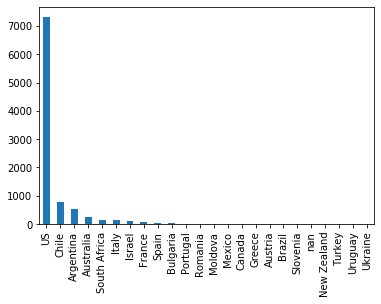

In [22]:
wine[wine['variety'] == 'Cabernet Sauvignon']['country'].value_counts().plot(kind='bar')

从直方图的统计结果看，US的数值最多。因此可认为品种为Cabernet Sauvignon的葡萄酒大部分产自于美国，从而认为此关联规则有效。